# Sentinel-2 Bathymetry workflow after ACOLITE atmospheric correction

In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import Affine
from rasterio.enums import Resampling
from rasterstats import point_query
import earthpy.plot as ep
from scipy import ndimage, stats
import matplotlib.pyplot as plt
import plotly.express as px

# Paths and Input Files

In [2]:
# Directories and Source Files
tile =  'T16PCC' #'T16QCE' # 'T16QDF' #
source_dir = '/Users/arbailey/natcap/idb/data/work/sentinel/acolite'
work_dir = '/Users/arbailey/natcap/idb/data/work/sentinel'
print(tile)

T16PCC


In [3]:
# Find associated band files from the source data
os.chdir(source_dir)
print(os.getcwd())
# This code assumes there is only one matching data set for the specific tile
# print(glob.glob('S2*MSI*' + tile + '_rhos_492.tif'))
# print(tile + '*rhos_49*.tif')
# print(glob.glob(tile + '*rhos_49*.tif'))
S2_L2R_blue = glob.glob('S2*MSI*' + tile + '_rhos_49*.tif')[0]
S2_L2R_green = glob.glob('S2*MSI*' + tile + '_rhos_5*.tif')[0]
S2_L2R_swir = glob.glob('S2*MSI*' + tile + '_rhos_16*.tif')[0]
print(S2_L2R_blue)
print(S2_L2R_green)
print(S2_L2R_swir)

/Users/arbailey/natcap/idb/data/work/sentinel/acolite
S2A_MSI_2020_02_06_16_14_31_T16PCC_rhos_492.tif
S2A_MSI_2020_02_06_16_14_31_T16PCC_rhos_560.tif
S2A_MSI_2020_02_06_16_14_31_T16PCC_rhos_1614.tif


In [4]:
# depth points  for Relative to Absolute bathymetry tuning
soundingpts_shp = "soundings_subset" + tile + "_32616.shp"
soundingpts_path = os.path.join(work_dir, soundingpts_shp)
output_points_shp = "sample_pts" + tile + "_32616.shp"
output_points_path = os.path.join(work_dir, output_points_shp)

# Get Data for Sentinel-2 bands: blue (B02), green (B03), and SWIR (B11)

In [5]:
blue_source = S2_L2R_blue
with rasterio.open(blue_source) as src:
    blue_profile = src.profile
    blue_np = src.read(1)
    print(blue_np)
    print(blue_profile)

[[       nan        nan        nan ... 0.02448936 0.02364384 0.02400623]
 [       nan        nan        nan ... 0.02412701 0.02400623 0.02473089]
 [       nan        nan        nan ... 0.02497244 0.02557619 0.02400623]
 ...
 [       nan        nan        nan ... 0.013968   0.01638916 0.01711522]
 [       nan        nan        nan ... 0.01590504 0.02098532 0.02291897]
 [       nan        nan        nan ... 0.01299911 0.01905074 0.02038087]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 1800000.0), 'tiled': False, 'interleave': 'band'}


In [6]:
green_source = S2_L2R_green
print(green_source)
with rasterio.open(green_source) as src:
    green_profile = src.profile
    green_np = src.read(1)
    print(green_np)
    print(green_profile)

S2A_MSI_2020_02_06_16_14_31_T16PCC_rhos_560.tif
[[       nan        nan        nan ... 0.01855586 0.01819646 0.01831627]
 [       nan        nan        nan ... 0.01723796 0.01795685 0.01819646]
 [       nan        nan        nan ... 0.01723796 0.01807666 0.01771723]
 ...
 [       nan        nan        nan ... 0.03100232 0.0382911  0.04008212]
 [       nan        nan        nan ... 0.03530493 0.05331964 0.05093658]
 [       nan        nan        nan ... 0.03171963 0.04831416 0.05129409]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 1800000.0), 'tiled': False, 'interleave': 'band'}


In [7]:
swir_source = S2_L2R_swir
print(swir_source)
with rasterio.open(swir_source) as src:
    swir_profile = src.profile
    swir_np = src.read(1)
    print(swir_np)
    print(swir_profile)

S2A_MSI_2020_02_06_16_14_31_T16PCC_rhos_1614.tif
[[       nan        nan        nan ... 0.00450579 0.00541164 0.00541164]
 [       nan        nan        nan ... 0.00450579 0.00541164 0.00541164]
 [       nan        nan        nan ... 0.00490839 0.00500904 0.00500904]
 ...
 [       nan        nan        nan ... 0.12966947 0.12343358 0.12343358]
 [       nan        nan        nan ... 0.13369252 0.15652153 0.15652153]
 [       nan        nan        nan ... 0.13369252 0.15652153 0.15652153]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 1800000.0), 'tiled': False, 'interleave': 'band'}


# Neighborhood Filter the Blue & Green bands

In [8]:
#--- Not doing filter before the ratio, so comment this out for now
# filter_size = 3 # square neighborhood
# blue_filtered = ndimage.median_filter(blue_np, size=filter_size)
# green_filtered = ndimage.median_filter(green_np, size=filter_size)

In [9]:
# # Plot Original and Filtered Bands
# # Blue
# fig = plt.figure(figsize=(20, 20))
# ax1 = fig.add_subplot(121)  # left side
# ax2 = fig.add_subplot(122)  # right side
# # plt.axis('off')
# ax1.imshow(blue_np)
# ax1.axis('off')
# ax1.set_title('Blue Band - Original', fontdict={'fontsize':20})
# ax2.imshow(blue_filtered)
# ax2.axis('off')
# ax2.set_title('Blue Band - Median Filter', fontdict={'fontsize':20})
# plt.show()
# # Green
# fig = plt.figure(figsize=(20, 20))
# ax1 = fig.add_subplot(121)  # left side
# ax2 = fig.add_subplot(122)  # right side
# ax1.imshow(green_np)
# ax1.axis('off')
# ax1.set_title('Green Band - Original', fontdict={'fontsize':20})
# ax2.imshow(green_filtered)
# ax2.axis('off')
# ax2.set_title('Green Band - Median Filter', fontdict={'fontsize':20})
# plt.show()


# Mask the Blue and Green Bands with the SWIR land/water threshold

In [10]:
# https://www.science-emergence.com/Articles/How-to-mask-an-array-using-another-array-in-python-/
# https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_where.html?highlight=masked_where
# Using a threshold value chosen from atmospherically corrected SWIR (B11) with Terrain Profile tool in QGIS 
swir_threshold = 0.08
# NOTE:  Inputing the original images, not the median filtered ones.   
blue_masked = np.ma.masked_invalid(blue_np)
blue_masked = np.ma.masked_where(swir_np > swir_threshold, blue_masked)
print(blue_np)
print(blue_masked)
green_masked = np.ma.masked_invalid(green_np)
green_masked = np.ma.masked_where(swir_np > swir_threshold, green_masked)
print(green_np)
print(green_masked)

/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


[[       nan        nan        nan ... 0.02448936 0.02364384 0.02400623]
 [       nan        nan        nan ... 0.02412701 0.02400623 0.02473089]
 [       nan        nan        nan ... 0.02497244 0.02557619 0.02400623]
 ...
 [       nan        nan        nan ... 0.013968   0.01638916 0.01711522]
 [       nan        nan        nan ... 0.01590504 0.02098532 0.02291897]
 [       nan        nan        nan ... 0.01299911 0.01905074 0.02038087]]
[[-- -- -- ... 0.024489358067512512 0.02364383637905121
  0.024006230756640434]
 [-- -- -- ... 0.02412700653076172 0.024006230756640434
  0.024730894714593887]
 [-- -- -- ... 0.02497243508696556 0.025576192885637283
  0.024006230756640434]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


[[       nan        nan        nan ... 0.01855586 0.01819646 0.01831627]
 [       nan        nan        nan ... 0.01723796 0.01795685 0.01819646]
 [       nan        nan        nan ... 0.01723796 0.01807666 0.01771723]
 ...
 [       nan        nan        nan ... 0.03100232 0.0382911  0.04008212]
 [       nan        nan        nan ... 0.03530493 0.05331964 0.05093658]
 [       nan        nan        nan ... 0.03171963 0.04831416 0.05129409]]
[[-- -- -- ... 0.018555864691734314 0.018196459859609604
  0.01831626519560814]
 [-- -- -- ... 0.017237955704331398 0.017956849187612534
  0.018196459859609604]
 [-- -- -- ... 0.017237955704331398 0.018076658248901367
  0.017717229202389717]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


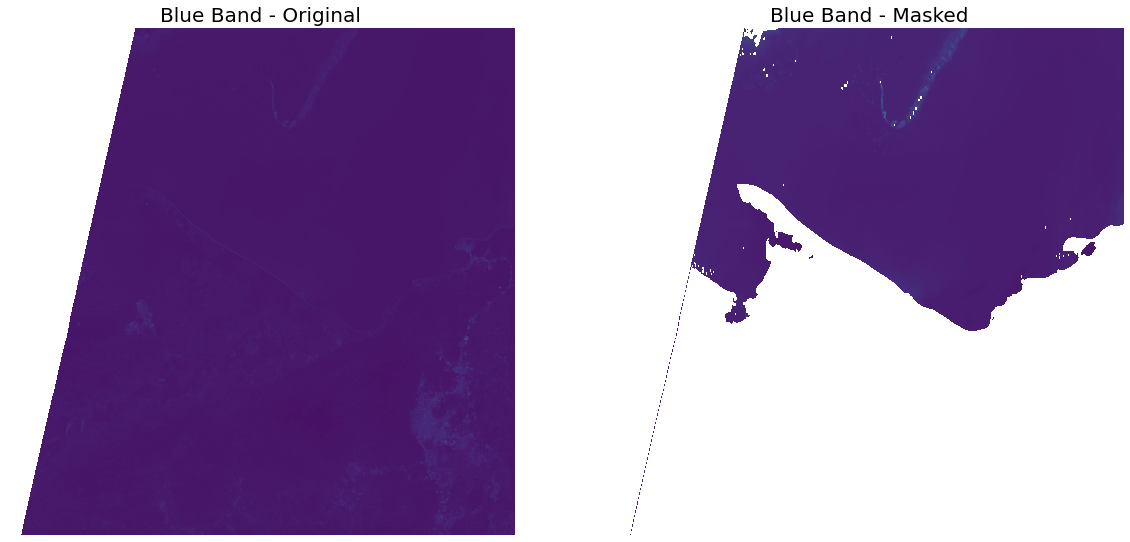

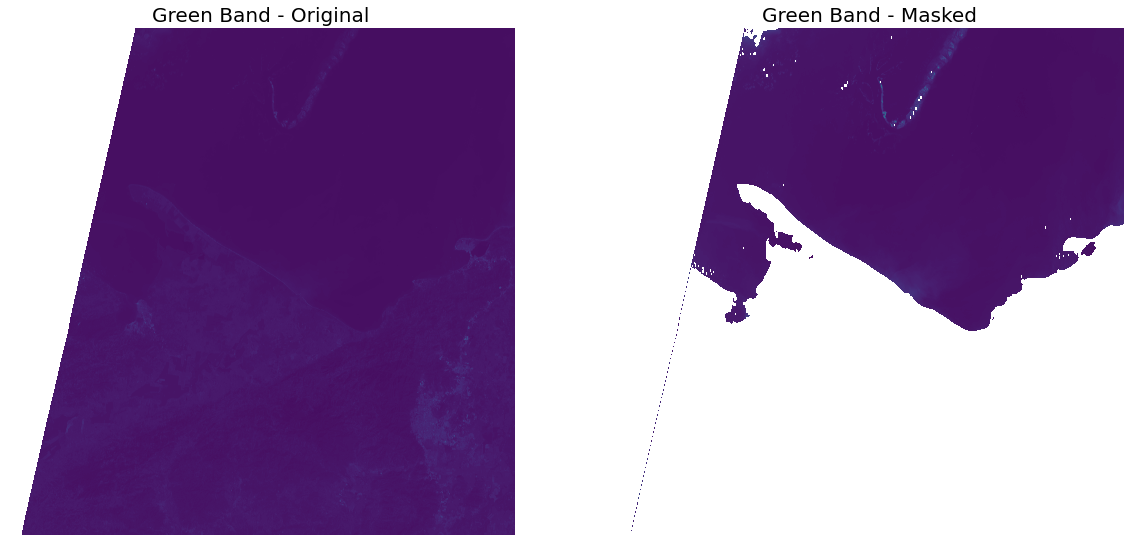

In [11]:
# Plot Original and Masked Bands
# Blue
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# plt.axis('off')
ax1.imshow(blue_np)
ax1.axis('off')
ax1.set_title('Blue Band - Original', fontdict={'fontsize':20})
ax2.imshow(blue_masked)
ax2.axis('off')
ax2.set_title('Blue Band - Masked', fontdict={'fontsize':20})
plt.show()
# Green
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(green_np)
ax1.axis('off')
ax1.set_title('Green Band - Original', fontdict={'fontsize':20})
ax2.imshow(green_masked)
ax2.axis('off')
ax2.set_title('Green Band - Masked', fontdict={'fontsize':20})
plt.show()

# Calculate Relative Bathymetry per Stumpf et al (2003) ratio method

In [12]:
# Stumpf ratio with constant (n) set to 1000, per Caballero & Stumpf, 2019
n = 1000
relative_bathy = np.log(n * blue_masked) / np.log(n * green_masked)
print(relative_bathy)

/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


[[-- -- -- ... 1.0949925184249878 1.0902637243270874 1.093034267425537]
 [-- -- -- ... 1.1180908679962158 1.1005349159240723 1.105757474899292]
 [-- -- -- ... 1.1301876306533813 1.1198914051055908 1.1056780815124512]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


In [13]:
stats.mstats.describe(relative_bathy, axis=None, ddof=1, bias=False)

DescribeResult(nobs=48233811, minmax=(masked_array(data=-2.8277662,
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=1.3790841,
             mask=False,
       fill_value=1e+20,
            dtype=float32)), mean=1.0621659565734916, variance=0.010282372131867194, skewness=masked_array(data=-5.61005083,
             mask=False,
       fill_value=1e+20), kurtosis=90.38871015717325)

In [14]:
stats.describe(relative_bathy, axis=None, ddof=1, bias=False)

DescribeResult(nobs=120560400, minmax=(-2.8277662, 1.3790841), mean=1.0621659565734916, variance=0.010282372131867194, skewness=4.662143230438232, kurtosis=313.78546142578125)

In [15]:
print(np.percentile(relative_bathy, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.nanpercentile(relative_bathy, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.ma.max(relative_bathy))
print(np.ma.min(relative_bathy))
# No difference between the NANpercentil and regular.   But, still have those extremely large and small numbers.  Not sure why

[0.38813844 0.88918948 0.97459102 1.         1.         1.
 1.         1.05098701 1.07567489 1.11862123 1.15149665 1.198524
 1.23791206]
[0.38813844 0.88918948 0.97459102 1.         1.         1.
 1.         1.05098701 1.07567489 1.11862123 1.15149665 1.198524
 1.23791206]
1.3790841
-2.8277662


In [16]:
# # Flatten relative bathy data to a 1D array for plotting
# relative_bathy_1D = relative_bathy.flatten()
# print(relative_bathy_1D)

In [17]:
#---- This is taking an unexpectedly long time to run -----
# Box plot to look for outlie
# fig = px.box(relative_bathy, y=relative_bathy_1D, points="all")
# fig = px.box(relative_bathy, y=relative_bathy_1D)
# fig.show()

In [18]:
# # Try converting to data frame
# relbathy_df = pd.DataFrame(relative_bathy_1D, columns=['rel_bathy'])
# relbathy_df

In [19]:
#--  Doesn't seem to spead it up at all. (never let it run to completion)
# fig = px.box(relative_bathy, y=relbathy_df['rel_bathy'], points="all")
# fig.show()                                       

In [20]:
# Describe results
print(relative_bathy.shape)
print(relative_bathy.ndim)
print(relative_bathy.dtype)
stats.describe(relative_bathy, axis=None)

(10980, 10980)
2
float32


DescribeResult(nobs=120560400, minmax=(-2.8277662, 1.3790841), mean=1.0621659565734916, variance=0.010282372131867194, skewness=4.662143230438232, kurtosis=313.78544046876095)

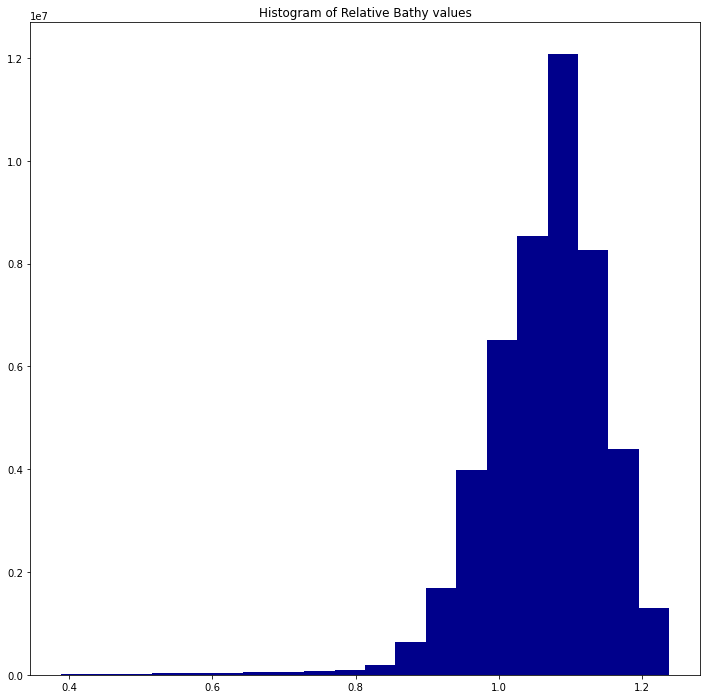

In [21]:
# Histogram with earthpy package -- Much faster than above
relbathy_plot_min = np.percentile(relative_bathy, 0.1)
relbathy_plot_max = np.percentile(relative_bathy, 99.9)
ep.hist(relative_bathy, 
        colors = 'darkblue',
        title="Histogram of Relative Bathy values",
       hist_range=([relbathy_plot_min, relbathy_plot_max])
       )
plt.show()

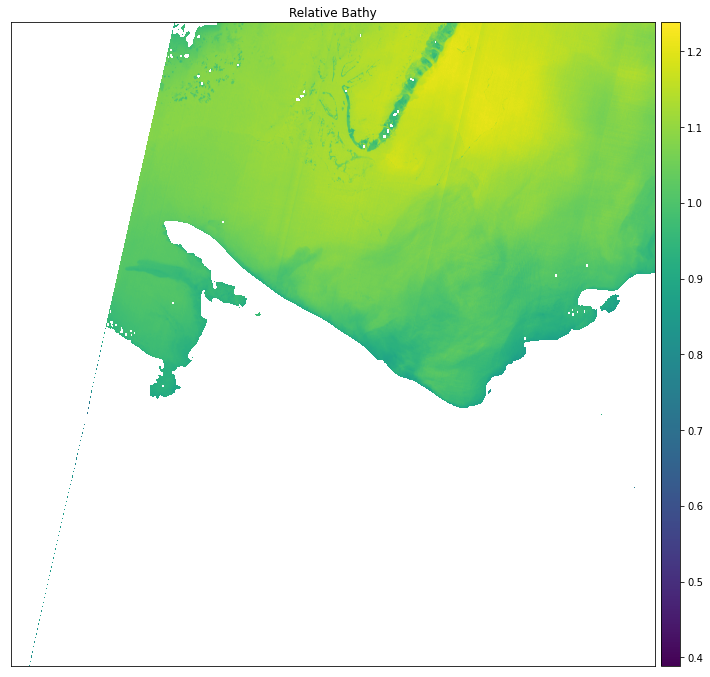

In [22]:
# Plot with earthpy package 
ep.plot_bands(relative_bathy, 
              cmap='viridis',
              title="Relative Bathy",
              scale=False,
             vmax=relbathy_plot_max,
             vmin=relbathy_plot_min)
plt.show()

# Export Relative Bathy to GeoTIFF

In [23]:
# Create Profile for new relative bathy raster
relbathy_profile = blue_profile
# Fill masked cells with no data value
nodatavalue = -9999.0
relative_bathy_nd = np.ma.filled(relative_bathy, fill_value=nodatavalue)
relbathy_profile.update({'nodata': nodatavalue})
print(relbathy_profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 1800000.0), 'tiled': False, 'interleave': 'band'}


In [24]:
# Output Relative Bathy as intermediate product
# Export to GeoTiff
out_file = tile + "_relbathy_acolite.tif"
out_path = os.path.join(work_dir, out_file)
print(out_path)

with rasterio.open(out_path, 'w', **relbathy_profile) as outf:
    outf.write(relative_bathy_nd, 1)

/Users/arbailey/natcap/idb/data/work/sentinel/T16PCC_relbathy_acolite.tif


# Sample Relative Bathy Raster with Sounding Points

In [25]:
depth_pts = gpd.read_file(soundingpts_path)
depth_pts

id  dep_dig  dep_m                        geometry
0      5432     44.0  13.41  POINT (347935.396 1799339.745)
1      5442     41.0  12.50  POINT (344133.255 1799324.461)
2      5443     32.0   9.75  POINT (342288.201 1799455.520)
3      5444     42.0  12.80  POINT (341093.495 1799354.774)
4      5448     29.0   8.84  POINT (339180.140 1799410.852)
...     ...      ...    ...                             ...
1273  10777    121.0  36.88  POINT (341500.190 1771418.447)
1274  10778     78.0  23.77  POINT (341107.283 1769828.641)
1275  10821    170.0  51.82  POINT (357182.784 1771042.452)
1276  10825    141.0  42.98  POINT (358853.942 1771191.860)
1277  10828    236.0  71.93  POINT (359018.098 1770339.810)

[1278 rows x 4 columns]

In [26]:
# Relative bathy values sampled from raster at sounding point locations  (uses rasterstats)
relbathy_pts = point_query(depth_pts, relative_bathy, 
                           affine=relbathy_profile['transform'], 
                           geojson_out=True,
                           property_name='reldep',
                           nodata=-99999
                          )
print(type(relbathy_pts))
relbathy_pts  # GeoJSOn object   -- list of GeoJSON objects

<class 'list'>


[{'id': '0',
  'type': 'Feature',
  'properties': {'dep_dig': 44.0,
   'dep_m': 13.41,
   'id': 5432,
   'reldep': 1.1030421749066008},
  'geometry': {'type': 'Point',
   'coordinates': (347935.39571494225, 1799339.7450513274)},
  'bbox': (347935.39571494225,
   1799339.7450513274,
   347935.39571494225,
   1799339.7450513274)},
 {'id': '1',
  'type': 'Feature',
  'properties': {'dep_dig': 41.0,
   'dep_m': 12.5,
   'id': 5442,
   'reldep': 1.073611830390166},
  'geometry': {'type': 'Point',
   'coordinates': (344133.2549077352, 1799324.4611343693)},
  'bbox': (344133.2549077352,
   1799324.4611343693,
   344133.2549077352,
   1799324.4611343693)},
 {'id': '2',
  'type': 'Feature',
  'properties': {'dep_dig': 32.0,
   'dep_m': 9.75,
   'id': 5443,
   'reldep': 1.0763905573259138},
  'geometry': {'type': 'Point',
   'coordinates': (342288.20094704186, 1799455.5204157243)},
  'bbox': (342288.20094704186,
   1799455.5204157243,
   342288.20094704186,
   1799455.5204157243)},
 {'id': '3',


In [27]:
from geojson import Feature, Point, FeatureCollection
collection = FeatureCollection(relbathy_pts)
depth_relbathy_pts = gpd.GeoDataFrame.from_features(collection['features'])

# Find Extinction Depth and Best Fit Linear Regression between depth points and relative bathymetry raster

In [28]:
# Full data set
fig = px.scatter(depth_relbathy_pts, x="reldep", y="dep_m")
fig.show()

In [29]:
# Change min/max variables and rerun cell to view updates to visualize approximate extinction depth value
min = 0 
max = 100
fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts["dep_m"] >= min) & 
                                        (depth_relbathy_pts["dep_m"] <= max)],
                                        x="reldep", y="dep_m")
fig.show()

In [45]:
# Use approximate extinction depth to plot regression 
min = 0
max = 25
fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts["dep_m"] >= min) & 
                                    (depth_relbathy_pts["dep_m"] <= max)], 
                                     x="reldep", y="dep_m", trendline="ols")
fig.show()
# https://www.statsmodels.org/stable/regression.html
results = px.get_trendline_results(fig)
print(results)
regression_params = results.px_fit_results.iloc[0].params
print(regression_params)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...
[-84.08192967  90.23718906]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     299.1
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           2.26e-56
Time:                        08:54:21   Log-Likelihood:                -2270.4
No. Observations:                 728   AIC:                             4545.
Df Residuals:                     726   BIC:                             4554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -84.0819      5.680    -14.802      0.000     -95.234     -72.930
x1            90.2372      5.218     17.293      0.000      79.993     100.481
==============================================================================
Omnibus:                       19.147   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.614
Skew:                           0.096   Prob(JB):                      0.00496
Kurtosis:                       2.441   Cond. No.                         56.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Apply regression to Relative Bathy per Stumpf (2003) equation

In [31]:
m0 = regression_params[0]
m1 = regression_params[1]
print(m1)
print(m0)

90.23718906160751
-84.08192967453263


In [32]:
sdb_grid = m1 * (relative_bathy) + m0
sdb_grid

masked_array(
  data=[[--, --, --, ..., 14.727119445800781, 14.300399780273438,
         14.550407409667969],
        [--, --, --, ..., 16.811447143554688, 15.227249145507812,
         15.698516845703125],
        [--, --, --, ..., 17.90302276611328, 16.973922729492188,
         15.691352844238281],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

In [33]:
# Describe results
print(sdb_grid.shape)
print(sdb_grid.ndim)
print(sdb_grid.dtype)
stats.describe(sdb_grid, axis=None)

(10980, 10980)
2
float32


DescribeResult(nobs=120560400, minmax=(-339.25162, 40.36274), mean=11.764986681230724, variance=83.72679055193035, skewness=-0.41454172134399414, kurtosis=-0.9070171951899977)

In [34]:
print(np.percentile(sdb_grid, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.nanpercentile(sdb_grid, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.max(sdb_grid))
print(np.min(sdb_grid))
# Not sure why there are these negative numbers

[-49.05741119  -3.84397125   3.86241913   7.59288025  12.95675659
  14.82746124  90.23719025  90.23719025  90.23719025  90.23719025
  90.23719025  90.23719025  90.23719025]
[-49.05741119  -3.84397125   3.86241913   7.59288025  12.95675659
  14.82746124  90.23719025  90.23719025  90.23719025  90.23719025
  90.23719025  90.23719025  90.23719025]
40.36274
-339.25162


# Plot the SDB results -- histogram and spatial plots

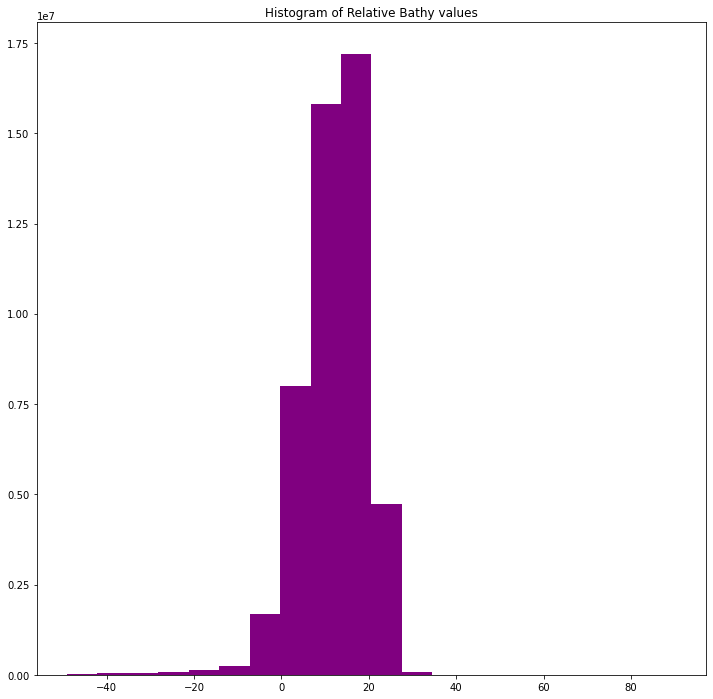

In [35]:
# SDB histogram
sdb_plot_min = np.percentile(sdb_grid, 0.1)
sdb_plot_max = np.percentile(sdb_grid, 99.9)
ep.hist(sdb_grid, 
        colors = 'purple',
        title="Histogram of Relative Bathy values",
       hist_range=([sdb_plot_min, sdb_plot_max])
       )
plt.show()

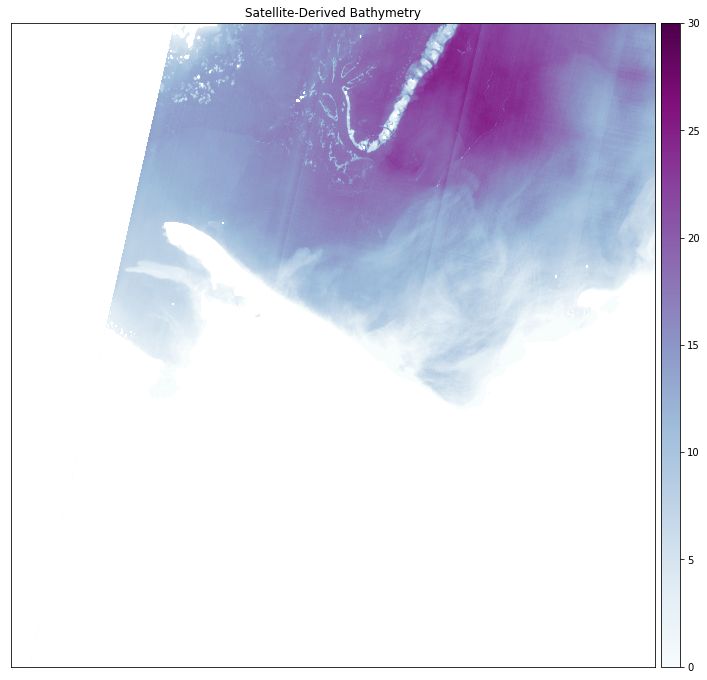

In [36]:
# Plot SDB grid
ep.plot_bands(sdb_grid, 
              cmap='BuPu',
              title="Satellite-Derived Bathymetry",
              scale=False,
              vmin=0,
              vmax=30, 
             )
plt.show()

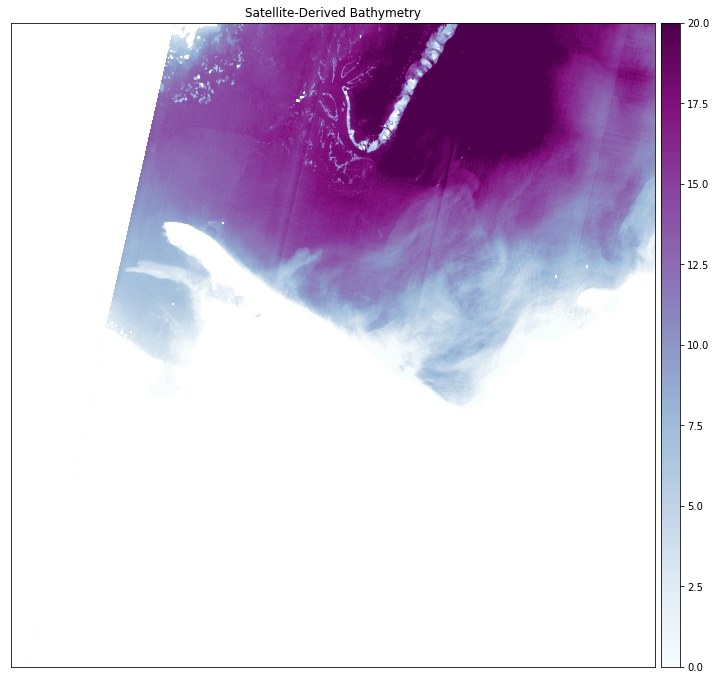

In [37]:
# Plot SDB grid
ep.plot_bands(sdb_grid, 
              cmap='BuPu',
              title="Satellite-Derived Bathymetry",
              scale=False,
              vmin=0,
              vmax=20, 
             )
plt.show()

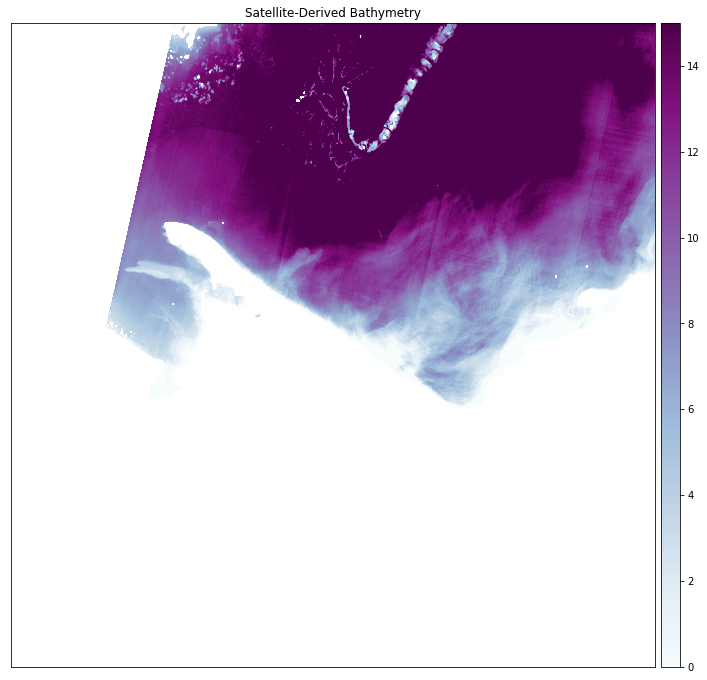

In [38]:
# Plot SDB grid
ep.plot_bands(sdb_grid, 
              cmap='BuPu',
              title="Satellite-Derived Bathymetry",
              scale=False,
              vmin=0,
              vmax=15, 
             )
plt.show()

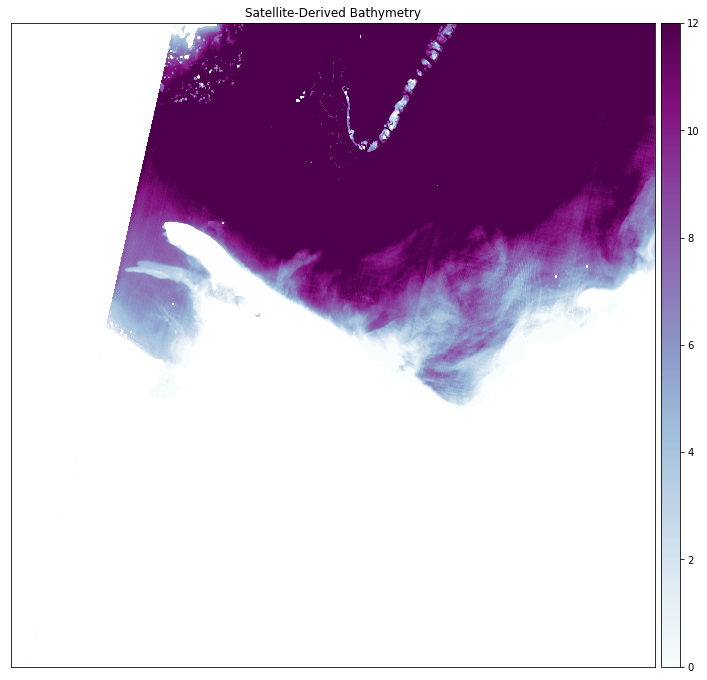

In [39]:
# Plot SDB grid
ep.plot_bands(sdb_grid, 
              cmap='BuPu',
              title="Satellite-Derived Bathymetry",
              scale=False,
              vmin=0,
              vmax=12, 
             )
plt.show()

# Export SDB to GeoTIFF

In [40]:
# Create Profile for new relative bathy raster
sdbprofile = relbathy_profile
# Fill masked cells with no data value
nodatavalue = -9999.0
sdb_bathy_nd = np.ma.filled(sdb_grid, fill_value=nodatavalue)
print(sdbprofile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 1800000.0), 'tiled': False, 'interleave': 'band'}


In [41]:
# Output Satellite-Derived Bathy 
# Export to GeoTiff
out_file = tile + "_sdb_acolite.tif"
out_path = os.path.join(work_dir, out_file)
print(out_path)

with rasterio.open(out_path, 'w', **sdbprofile) as outf:
    outf.write(sdb_bathy_nd, 1)

/Users/arbailey/natcap/idb/data/work/sentinel/T16PCC_sdb_acolite.tif


# Sample SDB with Sounding Points and Export

In [42]:
# Relative bathy values sampled from raster at sounding point locations  (uses rasterstats)
bathy_sample_pts = point_query(depth_relbathy_pts, sdb_grid, 
                           affine=sdbprofile['transform'], 
                           geojson_out=True,
                           property_name='sdbdep_m',
                           nodata=nodatavalue
                          )
print(type(bathy_sample_pts))
bathy_sample_pts  # GeoJSOn object   -- list of GeoJSON objects

<class 'list'>


[{'id': '0',
  'type': 'Feature',
  'properties': {'dep_dig': 44.0,
   'dep_m': 13.41,
   'id': 5432,
   'reldep': 1.1030421749066008,
   'sdbdep_m': 15.453493018027794},
  'geometry': {'type': 'Point',
   'coordinates': (347935.39571494225, 1799339.7450513274)},
  'bbox': (347935.39571494225,
   1799339.7450513274,
   347935.39571494225,
   1799339.7450513274)},
 {'id': '1',
  'type': 'Feature',
  'properties': {'dep_dig': 41.0,
   'dep_m': 12.5,
   'id': 5442,
   'reldep': 1.073611830390166,
   'sdbdep_m': 12.797783126964463},
  'geometry': {'type': 'Point',
   'coordinates': (344133.2549077352, 1799324.4611343693)},
  'bbox': (344133.2549077352,
   1799324.4611343693,
   344133.2549077352,
   1799324.4611343693)},
 {'id': '2',
  'type': 'Feature',
  'properties': {'dep_dig': 32.0,
   'dep_m': 9.75,
   'id': 5443,
   'reldep': 1.0763905573259138,
   'sdbdep_m': 13.048526688186103},
  'geometry': {'type': 'Point',
   'coordinates': (342288.20094704186, 1799455.5204157243)},
  'bbox': 

In [43]:
from geojson import Feature, Point, FeatureCollection
collection = FeatureCollection(bathy_sample_pts)
bathy_sample_pts = gpd.GeoDataFrame.from_features(collection['features'])
# Output point samples to shapefile
bathy_sample_pts.to_file(output_points_path)